#Criação do Spark Session / Carregamento dos Dados

In [1]:
!pip install pyspark

In [2]:
#criando a SparkSession

from pyspark.sql import SparkSession

sessao_spark = SparkSession\
                    .builder\
                    .appName('Case Cientista de Dados Jr')\
                    .getOrCreate()

sessao_spark

In [3]:
#extraindo os arquivos zipados

zip_name = '/content/basica202.zip'

import zipfile, os

extract_dir = 'csv_extraidos'

with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(extract_dir)

os.listdir(extract_dir)


['basica2023-08.txt',
 'basica2024-02.txt',
 'basica2024-08.txt',
 'basica2024-04.txt',
 'basica2023-05.txt',
 'basica2023-04.txt',
 'basica2024-05.txt',
 'basica2024-10.txt',
 'basica2023-07.txt',
 'basica2024-09.txt',
 'basica2025-01.txt',
 'basica2023-01.txt',
 'basica2024-12.txt',
 'basica2025-02.txt',
 'basica2023-06.txt',
 'basica2024-06.txt',
 'basica2024-07.txt',
 'basica2023-02.txt',
 'basica2023-11.txt',
 'basica2025-04.txt',
 'basica2025-05.txt',
 'basica2023-10.txt',
 'basica2023-09.txt',
 'basica2025-07.txt',
 'basica2023-03.txt',
 'basica2024-01.txt',
 'basica2023-12.txt',
 'basica2025-06.txt',
 'basica2024-03.txt',
 'basica2024-11.txt',
 'basica2025-03.txt']

In [4]:
# Caminho da pasta onde estão os arquivos

caminho = '/content/csv_extraidos/*.txt'

df = sessao_spark.read.csv(
    caminho,
    sep=';',
    header=True,
    inferSchema=True,
    encoding='latin1'
)

df.show(5)
print('Total de linhas:', df.count())

+---------+----------+---------------+---------------+--------------------+-------+--------------------+------+-----------+-----+-----+--------------------+-----------+-------------+-----------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+-----------------+--------------------+------------------------+-----------------+---------------------+-------------+-------------+----------------+----------------------+---------------------+-----------------+-------------------+---------------+-------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------+-------------------+----------------------+--------------------------+-------------------+-----------------------+-------------------+--------------+--------------+--------------------+--------------------+------------+----------------+--------------+--------------------+--------+-----------------

#Tratamento de dados

In [5]:
#import de spark functions

import pyspark.sql.functions as f
import pandas as pd

In [6]:
#schema das colunas
df.printSchema()

root
 |-- id_basica: integer (nullable = true)
 |-- id_empresa: integer (nullable = true)
 |-- sg_empresa_icao: string (nullable = true)
 |-- sg_empresa_iata: string (nullable = true)
 |-- nm_empresa: string (nullable = true)
 |-- nm_pais: string (nullable = true)
 |-- ds_tipo_empresa: string (nullable = true)
 |-- nr_voo: integer (nullable = true)
 |-- nr_singular: string (nullable = true)
 |-- id_di: integer (nullable = true)
 |-- cd_di: string (nullable = true)
 |-- ds_di: string (nullable = true)
 |-- ds_grupo_di: string (nullable = true)
 |-- dt_referencia: date (nullable = true)
 |-- nr_ano_referencia: integer (nullable = true)
 |-- nr_semestre_referencia: integer (nullable = true)
 |-- nm_semestre_referencia: string (nullable = true)
 |-- nr_trimestre_referencia: integer (nullable = true)
 |-- nm_trimestre_referencia: string (nullable = true)
 |-- nr_mes_referencia: integer (nullable = true)
 |-- nm_mes_referencia: string (nullable = true)
 |-- nr_semana_referencia: integer (nul

In [7]:
#quantidade de linhas
df.count()

2439018

In [8]:
#quantidade de colunas
len(df.columns)

111

In [9]:
#filtros de empresa, vôos domésticos e grupo regular

df_iata = df.filter(f.col('sg_empresa_iata').isin(['AD','G3','JJ']))
df_grupo = df_iata.filter(f.col('ds_grupo_di').isin('REGULAR'))
df_filtrado = df_grupo.filter(f.col('ds_natureza_etapa').isin('DOMÉSTICA'))

df_filtrado.select('ds_natureza_etapa', 'ds_grupo_di', 'sg_empresa_iata').distinct().show()

+-----------------+-----------+---------------+
|ds_natureza_etapa|ds_grupo_di|sg_empresa_iata|
+-----------------+-----------+---------------+
|        DOMÉSTICA|    REGULAR|             JJ|
|        DOMÉSTICA|    REGULAR|             AD|
|        DOMÉSTICA|    REGULAR|             G3|
+-----------------+-----------+---------------+



In [10]:
#contagem de valores nulos

df_filtrado.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df_filtrado.columns]).show()

+---------+----------+---------------+---------------+----------+-------+---------------+------+-----------+-----+-----+-----+-----------+-------------+-----------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+-----------------+--------------------+------------------------+-----------------+---------------------+-------------+-------------+-------------+----------------------+---------------------+-----------------+---------------+---------------+-------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------+-------------------+----------------------+--------------------------+-------------------+-----------------------+-------------------+--------------+--------------+-------------------+-------------------+------------+----------------+--------------+--------------------+--------+---------------+---------------+-------------------+----

In [11]:
#remoção da coluna nr_escala_destino, que não tem nenhum registro

df_filtrado = df_filtrado.drop('nr_escala_destino')
df_filtrado.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df_filtrado.columns]).show()

+---------+----------+---------------+---------------+----------+-------+---------------+------+-----------+-----+-----+-----+-----------+-------------+-----------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+-----------------+--------------------+------------------------+-----------------+---------------------+-------------+-------------+-------------+----------------------+---------------------+-----------------+---------------+---------------+-------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------+-------------------+----------------------+--------------------------+-------------------+-----------------------+-------------------+--------------+--------------+-------------------+-------------------+------------+----------------+--------------+--------------------+--------+---------------+---------------+-------------------+----

In [12]:
#subtituição dos nulo da coluna nr_chave por 0

df_fill = df_filtrado.na.fill({'nr_chave': 0})
df_fill.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in df_fill.columns]).show()

+---------+----------+---------------+---------------+----------+-------+---------------+------+-----------+-----+-----+-----+-----------+-------------+-----------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+-----------------+--------------------+------------------------+-----------------+---------------------+-------------+-------------+-------------+----------------------+---------------------+-----------------+---------------+---------------+-------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------+-------------------+----------------------+--------------------------+-------------------+-----------------------+-------------------+--------------+--------------+-------------------+-------------------+------------+----------------+--------------+--------------------+--------+---------------+---------------+-------------------+----

In [13]:
#remoção de serviços do tipo cargueiro

df_fill = df_fill.filter(f.col('ds_servico_tipo_linha') != 'CARGUEIRO')
df_fill.show(5)

+---------+----------+---------------+---------------+--------------------+-------+--------------------+------+-----------+-----+-----+--------------------+-----------+-------------+-----------------+----------------------+----------------------+-----------------------+-----------------------+-----------------+-----------------+--------------------+------------------------+-----------------+---------------------+-------------+-------------+---------------+----------------------+---------------------+-----------------+-------------------+---------------+-------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------+-------------------+----------------------+--------------------------+-------------------+-----------------------+-------------------+--------------+--------------+-------------------+-------------------+------------+----------------+--------------+--------------------+--------+-------------------+

In [14]:
#seleciona as colunas e cria a coluna passageiros_totais e load factor raw(1 = 100% vendido)
df_metricas = df_fill.select(
                        'sg_empresa_iata',
                        'dt_partida_real',
                        'nr_assentos_ofertados',
                        'nr_passag_pagos',
                        'nr_passag_gratis',
                        'km_distancia',
                        'nr_ask',
                        'nr_rpk')\
                    .withColumn('total_passageiros', f.col('nr_passag_pagos') + f.col('nr_passag_gratis'))\
                    .withColumn('load_factor_raw',f.when(f.col('nr_ask') > 0, f.col('nr_rpk') / f.col('nr_ask')).otherwise(f.lit(None)))\
                    .withColumn('load_factor_raw',f.when(f.col('load_factor_raw') > 1, 1).otherwise(f.col('load_factor_raw')))


df_metricas.show(5)


#nr_ask = assentos disponíveis por km voado (A = assentos)

#nr_rpk = passageiros por km voado (RP = passageiros)

+---------------+---------------+---------------------+---------------+----------------+------------+------+------+-----------------+------------------+
|sg_empresa_iata|dt_partida_real|nr_assentos_ofertados|nr_passag_pagos|nr_passag_gratis|km_distancia|nr_ask|nr_rpk|total_passageiros|   load_factor_raw|
+---------------+---------------+---------------------+---------------+----------------+------------+------+------+-----------------+------------------+
|             JJ|     2025-01-07|                  220|            209|               0|        1705|375100|356345|              209|              0.95|
|             JJ|     2025-01-03|                  172|            146|               1|        1705|293260|248930|              147|0.8488372093023255|
|             G3|     2025-01-17|                  186|            142|               9|         458| 85188| 65036|              151|0.7634408602150538|
|             G3|     2025-01-28|                  153|             95|           

In [15]:
#agregado por dia e por companhia aérea calculando o load factordiário
df_diario = df_metricas.filter(f.year("dt_partida_real") != 2022)\
                       .filter(~((f.year("dt_partida_real") == 2025) & (f.month("dt_partida_real") == 8)))\
                       .groupBy('sg_empresa_iata', 'dt_partida_real')\
                       .agg(f.sum('nr_ask').alias('ASK_dia'),
                            f.sum('nr_rpk').alias('RPK_dia'),
                            f.sum('nr_assentos_ofertados').alias('assentos_ofertados_dia'),
                            f.sum('total_passageiros').alias('total_passageiros_dia'),
                            f.count('*').alias('qtd_etapas_dia'))\
                       .withColumn('load_factor_dia', f.when(f.col('ASK_dia') > 0, f.col('RPK_dia') / f.col('ASK_dia')).otherwise(f.lit(None)))\
                       .orderBy('dt_partida_real')

df_diario.show(10, truncate=False)


#nr_ask = assentos disponíveis por km voado (A = assentos)

#nr_rpk = passageiros por km voado (RP = passageiros)


+---------------+---------------+---------+---------+----------------------+---------------------+--------------+------------------+
|sg_empresa_iata|dt_partida_real|ASK_dia  |RPK_dia  |assentos_ofertados_dia|total_passageiros_dia|qtd_etapas_dia|load_factor_dia   |
+---------------+---------------+---------+---------+----------------------+---------------------+--------------+------------------+
|AD             |2023-01-01     |59549727 |46974525 |58555                 |46774                |443           |0.7888285533198163|
|JJ             |2023-01-01     |115149799|92654525 |103498                |80674                |580           |0.8046433932550764|
|G3             |2023-01-01     |76365825 |63485579 |74458                 |61949                |430           |0.8313349459656856|
|JJ             |2023-01-02     |136311250|113883450|126445                |101583               |705           |0.8354662582875588|
|AD             |2023-01-02     |94686253 |82152052 |99785           

#EDA

In [16]:
#mostramos a media, mediana, min e max e desvio padrão do load factor por companhia
stats = (df_diario.groupBy('sg_empresa_iata')
                  .agg(
                      f.expr('percentile_approx(load_factor_dia, 0.5)').alias('mediana_LF'),
                      f.avg('load_factor_dia').alias('media_LF'),
                      f.stddev('load_factor_dia').alias('desvio_LF'),
                      f.min('load_factor_dia').alias('min_LF'),
                      f.max('load_factor_dia').alias('max_LF'),
                      f.count('*').alias('dias_observados'))
                 .orderBy('sg_empresa_iata'))

stats.show(truncate=False)


+---------------+------------------+------------------+--------------------+------------------+------------------+---------------+
|sg_empresa_iata|mediana_LF        |media_LF          |desvio_LF           |min_LF            |max_LF            |dias_observados|
+---------------+------------------+------------------+--------------------+------------------+------------------+---------------+
|AD             |0.8060307223710778|0.8028961265845862|0.04479931729430311 |0.594594831857773 |0.9125452976512146|943            |
|G3             |0.8307009782350132|0.8270735039669118|0.03917999061318815 |0.6738733095569768|0.9218499555722492|943            |
|JJ             |0.8281323096703899|0.8218210757878136|0.043029290127786994|0.6772073683295403|0.9181995038296593|943            |
+---------------+------------------+------------------+--------------------+------------------+------------------+---------------+



In [17]:


df_mes = (df_diario
    .withColumn("ano_mes", f.date_format("dt_partida_real", "yyyy-MM"))
    .groupBy("sg_empresa_iata", "ano_mes")
    .agg(
        f.avg("load_factor_dia").alias("lf_medio")
      )
    .orderBy("sg_empresa_iata", "ano_mes")
)

df_mes.show(31, truncate=False)


+---------------+-------+------------------+
|sg_empresa_iata|ano_mes|lf_medio          |
+---------------+-------+------------------+
|AD             |2023-01|0.8250120501077559|
|AD             |2023-02|0.7754205642073975|
|AD             |2023-03|0.7774696530118067|
|AD             |2023-04|0.780985526812884 |
|AD             |2023-05|0.7833439035497245|
|AD             |2023-06|0.7932855937250061|
|AD             |2023-07|0.8182693948077843|
|AD             |2023-08|0.8043386252560963|
|AD             |2023-09|0.7968505288987484|
|AD             |2023-10|0.7875591702357126|
|AD             |2023-11|0.7819611467677381|
|AD             |2023-12|0.794345166715157 |
|AD             |2024-01|0.8319994861060092|
|AD             |2024-02|0.7322378520725188|
|AD             |2024-03|0.7681142036870852|
|AD             |2024-04|0.7564665958243608|
|AD             |2024-05|0.7925869159508199|
|AD             |2024-06|0.8123654008422588|
|AD             |2024-07|0.8203933155636536|
|AD       

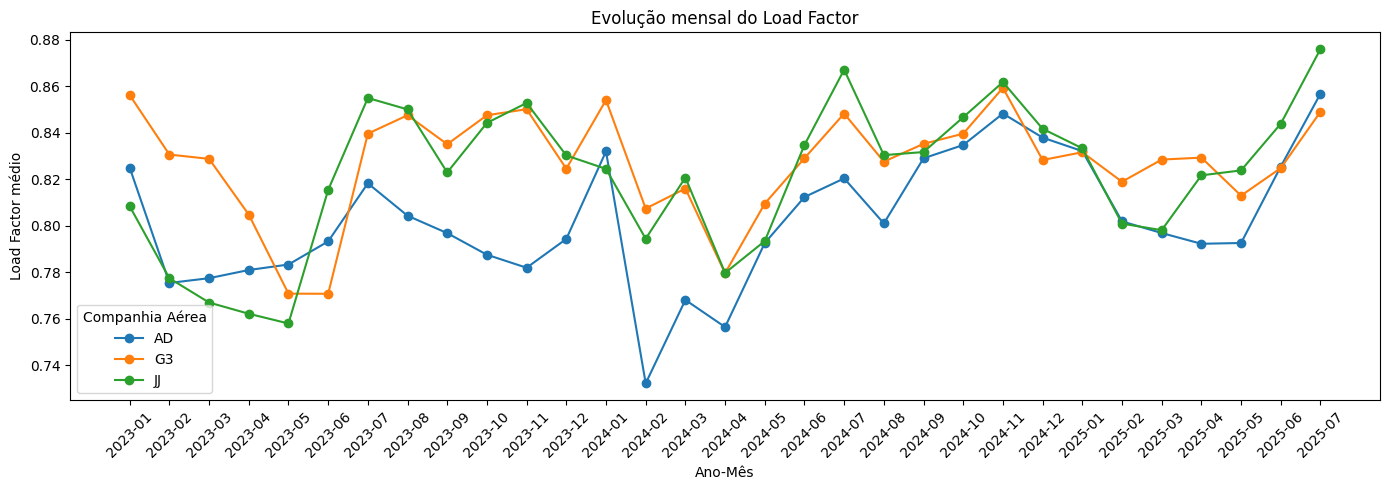

In [18]:
#gráfico de linha mostrando o comportamento do LF ao longo dos meses para cada companhia
#itera por cada linha de cada companhia
import matplotlib.pyplot as plt

df_mes = (df_diario.withColumn('ano_mes', f.date_format('dt_partida_real','yyyy-MM'))
                   .groupBy('sg_empresa_iata','ano_mes')
                   .agg(f.avg('load_factor_dia').alias('lf_medio'))
                   .orderBy('sg_empresa_iata','ano_mes')
                   .toPandas())

plt.figure(figsize=(14,5))
for c, l in df_mes.groupby('sg_empresa_iata'):
    plt.plot(l['ano_mes'], l['lf_medio'], marker='o', label=c)

plt.xticks(rotation=45)
plt.title('Evolução mensal do Load Factor')
plt.xlabel('Ano-Mês')
plt.ylabel('Load Factor médio')
plt.legend(title='Companhia Aérea')
plt.tight_layout()
plt.show()



In [19]:
#cria o df com o load factor medio por dia da semana para cada uma das 3 companhias
df_semana = (df_diario.withColumn('dia_semana', f.date_format('dt_partida_real', 'E'))
                     .groupBy('sg_empresa_iata', 'dia_semana')
                     .agg(f.avg('load_factor_dia').alias('load_factor_medio'),
                          f.count('*').alias('qtd_etapas'))
                     .orderBy('sg_empresa_iata', 'dia_semana'))

df_semana.show(21, truncate=False)


+---------------+----------+------------------+----------+
|sg_empresa_iata|dia_semana|load_factor_medio |qtd_etapas|
+---------------+----------+------------------+----------+
|AD             |Fri       |0.7943422445570681|134       |
|AD             |Mon       |0.7940779199767584|135       |
|AD             |Sat       |0.8215111516096183|134       |
|AD             |Sun       |0.8069017826032735|135       |
|AD             |Thu       |0.8042046902609647|135       |
|AD             |Tue       |0.8002906474481268|135       |
|AD             |Wed       |0.7990189766214587|135       |
|G3             |Fri       |0.8358034111091364|134       |
|G3             |Mon       |0.8412272322284239|135       |
|G3             |Sat       |0.823393264706816 |134       |
|G3             |Sun       |0.8501852386341553|135       |
|G3             |Thu       |0.8225005610435697|135       |
|G3             |Tue       |0.8051527731148846|135       |
|G3             |Wed       |0.8112894518786702|135      

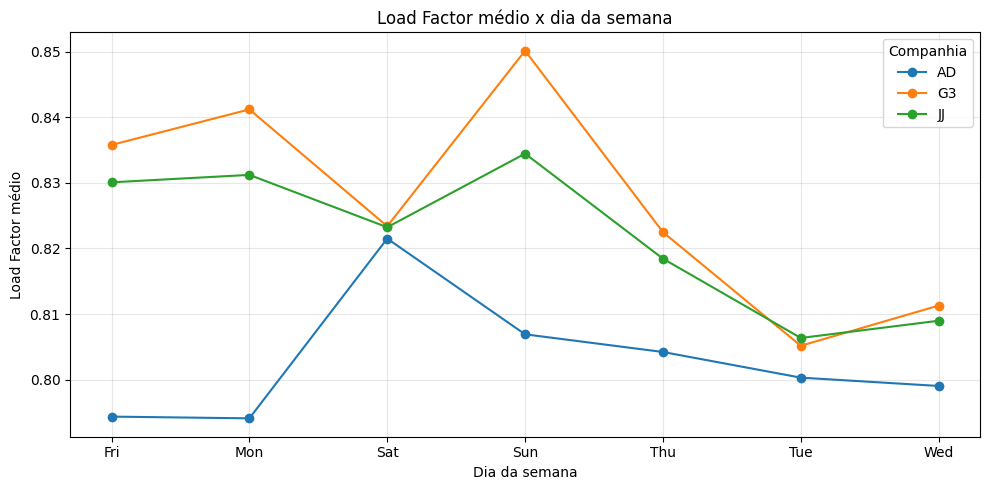

In [20]:
#mostra no gráfico a mesma informação da célula anterior, sendo a Azul a companhia com o menor valor médio de load factor
p_df_semana = df_semana.toPandas()

plt.figure(figsize=(10,5))
for c, l in p_df_semana.groupby('sg_empresa_iata'):
    plt.plot(l['dia_semana'], l['load_factor_medio'], marker="o", label=c)

plt.title('Load Factor médio x dia da semana')
plt.xlabel('Dia da semana')
plt.ylabel('Load Factor médio')
plt.legend(title='Companhia')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


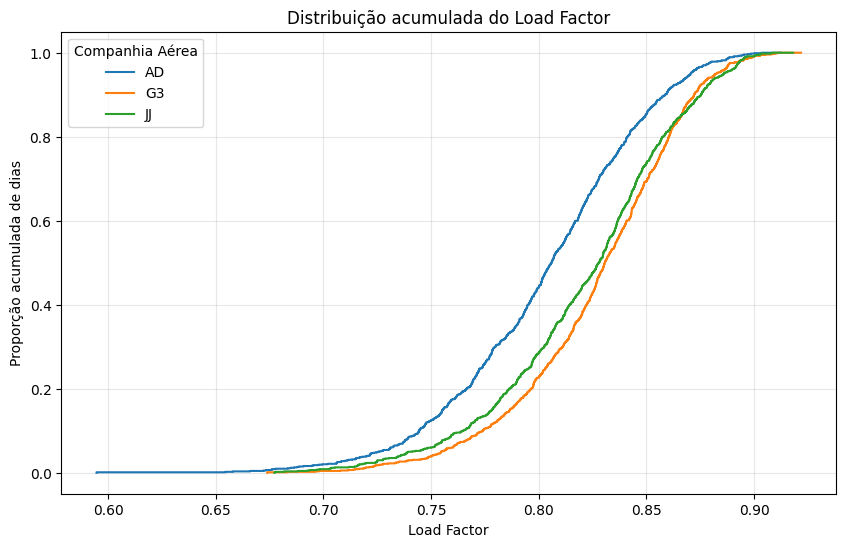

In [21]:
#mostra como se distribuem os valores do LF em comparação com a proporção de dias. Dá pra ver quantos 'dias' cada companhia vôou com qual ocupação
import numpy as np

p_df = df_diario.select('sg_empresa_iata','load_factor_dia').toPandas()

plt.figure(figsize=(10,6))
for c, l in p_df.groupby('sg_empresa_iata'):
    vals = np.sort(l['load_factor_dia'].dropna())
    y = np.arange(1, len(vals)+1) / len(vals)
    plt.step(vals, y, label=c)

plt.title('Distribuição acumulada do Load Factor')
plt.xlabel('Load Factor')
plt.ylabel('Proporção acumulada de dias')
plt.legend(title='Companhia Aérea')
plt.grid(alpha=0.3)
plt.show()
